## Loading file

In [1]:
import pandas as pd
df = pd.read_csv("Bank-full.csv", sep=';')

In [2]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Explolatory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


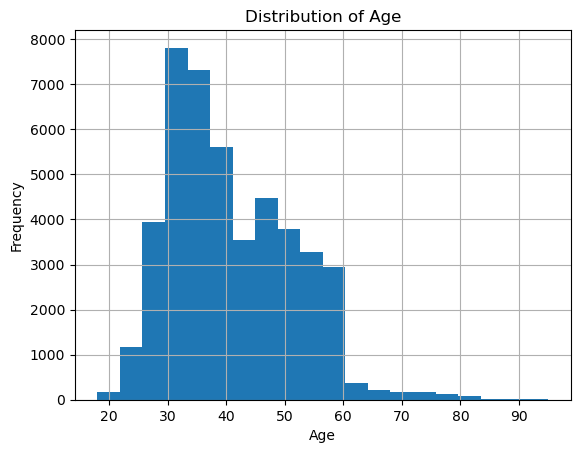

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Histogram for 'age'
df['age'].hist(bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

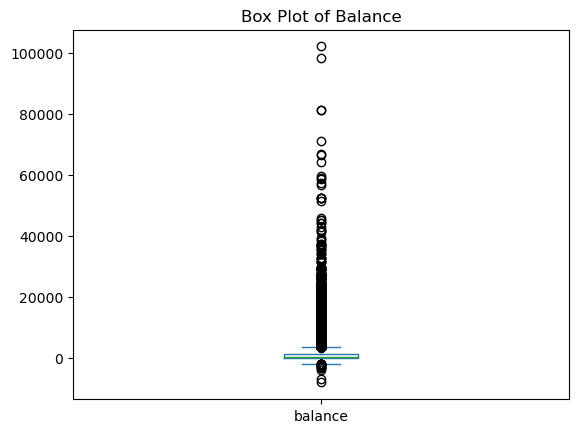

In [5]:
# Box plot for 'balance'
df['balance'].plot(kind='box')
plt.title('Box Plot of Balance')
plt.show()

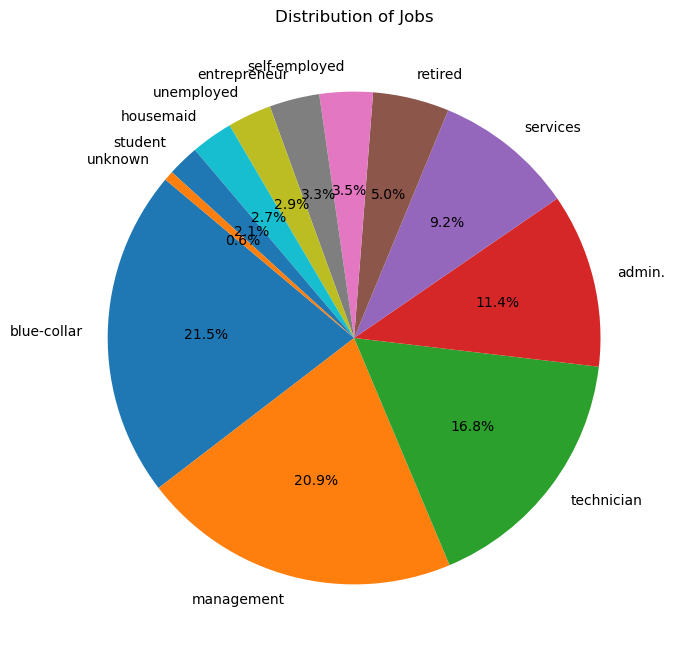

In [6]:
# Function to create a pie chart for a given column
def plot_pie_chart(df, column, title):
    plt.figure(figsize=(8, 8))
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.ylabel('')  # Hide the y-label
    plt.show()

# Pie chart for 'job'
plot_pie_chart(df, 'job', 'Distribution of Jobs')


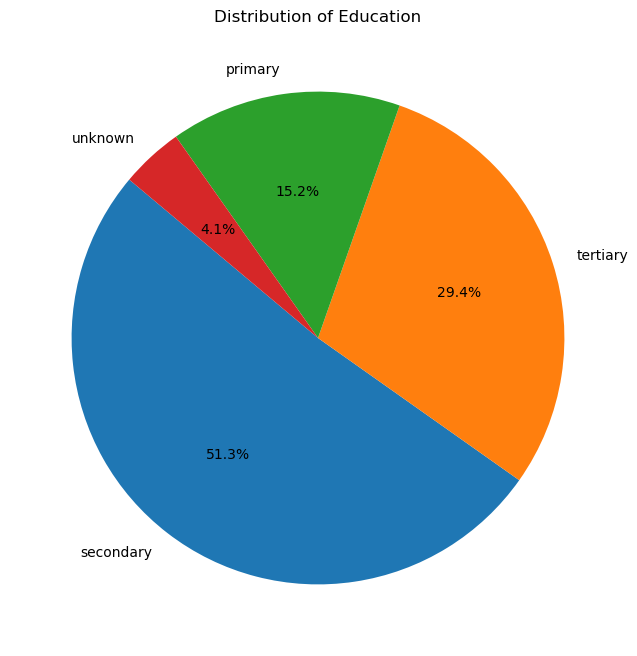

In [7]:
# Pie chart for 'job'
plot_pie_chart(df, 'education', 'Distribution of Education')

## Outlier Removal

We are proceeding to remove only the outliers for balance and duration as they have quite a lot outliers. We are using the Z score removal method to remove outliers lying above the 4 sigma deviation standards. Before doing that we are also proceeding with encoding target variable

#### Encoding target variable

In [8]:
import numpy as np
from scipy import stats

# Replace 'no' with 0 and 'yes' with 1 in the 'y' column
df['y'] = df['y'].replace({'no': 0, 'yes': 1})


#### Outlier removal

In [9]:
z_scores = stats.zscore(df['balance'])
threshold = 4
outlier_indices = np.where(z_scores > threshold)[0]  # Extracting the array of indices

# Filtering the DataFrame to exclude outliers
df_filtered = df.drop(outlier_indices)

# Reset the index of df_filtered to ensure alignment
df_filtered = df_filtered.reset_index(drop=True)

# Recalculate Z-scores on the filtered DataFrame
z_scores = stats.zscore(df_filtered['duration'])
threshold = 4

# Find the indices of outliers in the filtered DataFrame
outlier_indices = np.where(z_scores > threshold)[0]

# Drop these outliers from df_filtered
df1 = df_filtered.drop(outlier_indices)

## Data Transformation

#### Building Pipeline

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.sparse import hstack

# List of categorical, numeric, and ordinal columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month']
numeric_cols = ['age','balance', 'duration', 'campaign', 'pdays','day']
ordinal_cols = ['previous']

# Create transformers for scaling, encoding, and ordinal encoding
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])


# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)])

#### Splitting data, applying SMOTE

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Using the pipeline from imblearn to include SMOTE
import pandas as pd
import time
from xgboost import XGBClassifier

# Splitting the data
y = df1['y']
X = df1.drop('y', axis=1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing to the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Applying SMOTE only to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)


## Building Gradient Boosting Model

In [12]:
import time
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Hyperparameters to try
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.5]
}

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', gb_classifier)])

# Define scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Initialize GridSearchCV with the pipeline, parameter grid, and desired cross-validation folds
grid_search = GridSearchCV(pipeline, param_grid, scoring=scorers, refit='recall', return_train_score=True, cv=4)

# Start the timer
start_time = time.time()

# Perform the grid search over the data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

# The best hyperparameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# Make predictions on the full test set using the best estimator
y_pred_gb = grid_search.predict(X_test)

# Calculate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
conf_matrix = confusion_matrix(y_test, y_pred_gb)
TN, FP, FN, TP = conf_matrix.ravel()

# Store the overall results
results = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
    'test_accuracy': accuracy_gb,
    'test_f1_score': f1_gb,
    'test_precision': precision_gb,
    'test_recall': recall_gb,
    'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
    'processing_time_sec': processing_time
}

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame([results])

# Display the results
results_df


/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics

/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__learning_rate': 0.5, 'classifier__max_depth': 7, 'classifier__n_estimators': 150}
Best cross-validated score: 0.4963751318541738


,best_params,best_score,test_accuracy,test_f1_score,test_precision,test_recall,TP,TN,FP,FN,processing_time_sec
0,"{'classifier__learning_rate': 0.5, 'classifier...",0.496375,0.902164,0.515625,0.56068,0.477273,462,7542,362,506,2819.298945


## Building XGBoost Model

In [13]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier

# Hyperparameters to try
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.5]
}

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_classifier)])

# Define scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Initialize GridSearchCV with the pipeline, parameter grid, and desired cross-validation folds
grid_search = GridSearchCV(pipeline, param_grid, scoring=scorers, refit='recall', return_train_score=True, cv=4)

# Start the timer
start_time = time.time()

# Perform the grid search over the data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

# The best hyperparameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# Make predictions on the full test set using the best estimator
y_pred_xgb = grid_search.predict(X_test)

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
TN, FP, FN, TP = conf_matrix.ravel()

# Store the overall results
results = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
    'test_accuracy': accuracy_xgb,
    'test_f1_score': f1_xgb,
    'test_precision': precision_xgb,
    'test_recall': recall_xgb,
    'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
    'processing_time_sec': processing_time
}

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame([results])

# Display the results
results_df


/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/metrics

Best parameters: {'classifier__learning_rate': 0.5, 'classifier__max_depth': 7, 'classifier__n_estimators': 150}
Best cross-validated score: 0.4856388621358681


,best_params,best_score,test_accuracy,test_f1_score,test_precision,test_recall,TP,TN,FP,FN,processing_time_sec
0,"{'classifier__learning_rate': 0.5, 'classifier...",0.485639,0.911294,0.548997,0.616474,0.494835,479,7606,298,489,70.051202


## Ensemble Model

I have built an customised ensemble model by combining the best performances of all other individuals. I have tried implementing it through soft voting as well as hard voting

## Defining ensembles

In [14]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier


# Define models
log_reg = LogisticRegression()
svc = SVC(kernel='linear', C=1.25, gamma='scale')
mlp = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(5, 9), activation='logistic')
knn = KNeighborsClassifier(n_neighbors=1)
xgboost = xgb.XGBClassifier(n_estimators=150, max_depth=7, learning_rate=0.5)
grad_boost = GradientBoostingClassifier(learning_rate=0.5, max_depth=7, n_estimators=150)
dt1 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5)
nb = GaussianNB(var_smoothing=7.742636826811278e-07)
dt2 = DecisionTreeClassifier(ccp_alpha=0.0, max_depth=10, min_samples_leaf=6, min_samples_split=20)
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300)


### Hard Voting

In [15]:
# Define the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_reg), ('svm', svc), ('mlp', mlp), ('knn', knn), 
    ('xgb', xgboost), ('gb', grad_boost), ('dt1', dt1), ('nb', nb), 
    ('dt2', dt2), ('rf', rf)], voting='hard')

# Create an imbalanced-learn pipeline with SMOTE and the Voting Classifier
voting_pipeline = ImbPipeline(steps=[('smote', smote), ('classifier', voting_clf)])

# Function to print metrics
def print_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

# Fit and evaluate the pipeline
voting_pipeline.fit(X_train_smote, y_train_smote)
y_pred_voting = voting_pipeline.predict(X_test_transformed)

print("Voting Classifier Metrics:")
print_metrics(y_test, y_pred_voting)

/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier Metrics:
Accuracy: 0.890892696122633
Precision: 0.5
Recall: 0.737603305785124
F1 Score: 0.5959933222036728


### Soft Voting and ROC curve

/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/varunraghav/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier Metrics:
Accuracy: 0.8970919747520288
Precision: 0.5202652910832719
Recall: 0.7293388429752066
F1 Score: 0.6073118279569891
ROC AUC Score: 0.9290658877605648


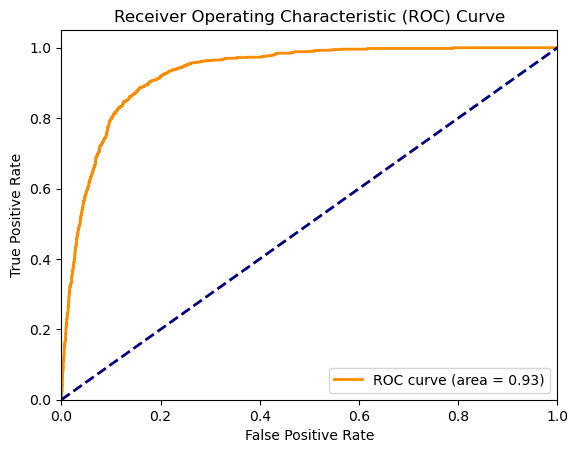

In [16]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Define the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_reg), ('mlp', mlp), ('knn', knn), 
    ('xgb', xgboost), ('gb', grad_boost), ('dt1', dt1), ('nb', nb), 
    ('dt2', dt2), ('rf', rf)], voting='soft')

# Create an imbalanced-learn pipeline with SMOTE and the Voting Classifier
voting_pipeline = ImbPipeline(steps=[('smote', smote), ('classifier', voting_clf)])

# Function to print metrics
def print_metrics(y_true, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_proba))

# Fit and evaluate the pipeline
voting_pipeline.fit(X_train_smote, y_train_smote)
y_pred_voting = voting_pipeline.predict(X_test_transformed)


y_proba_voting = voting_pipeline.predict_proba(X_test_transformed)[:, 1]
print("Voting Classifier Metrics:")
print_metrics(y_test, y_pred_voting, y_proba_voting)


# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_proba_voting)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
